In [1]:
# Pour que les changements dans les modules importés (par exemple soap_utils.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

Utiliser le code de la cellule ci-dessous pour désactiver le scrolling quand l'affichage est long.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 4
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

In [5]:
from pathlib import Path
image_path = Path('../../data/images/')
sound_path = Path('../../data/sons_int2/')

In [6]:
from keras.models import Sequential
from keras.layers import Conv1D


# Apprendre un filtre qui débruite
On cherche à apprendre à enlever le bruit ajouté à une sinusoïde.

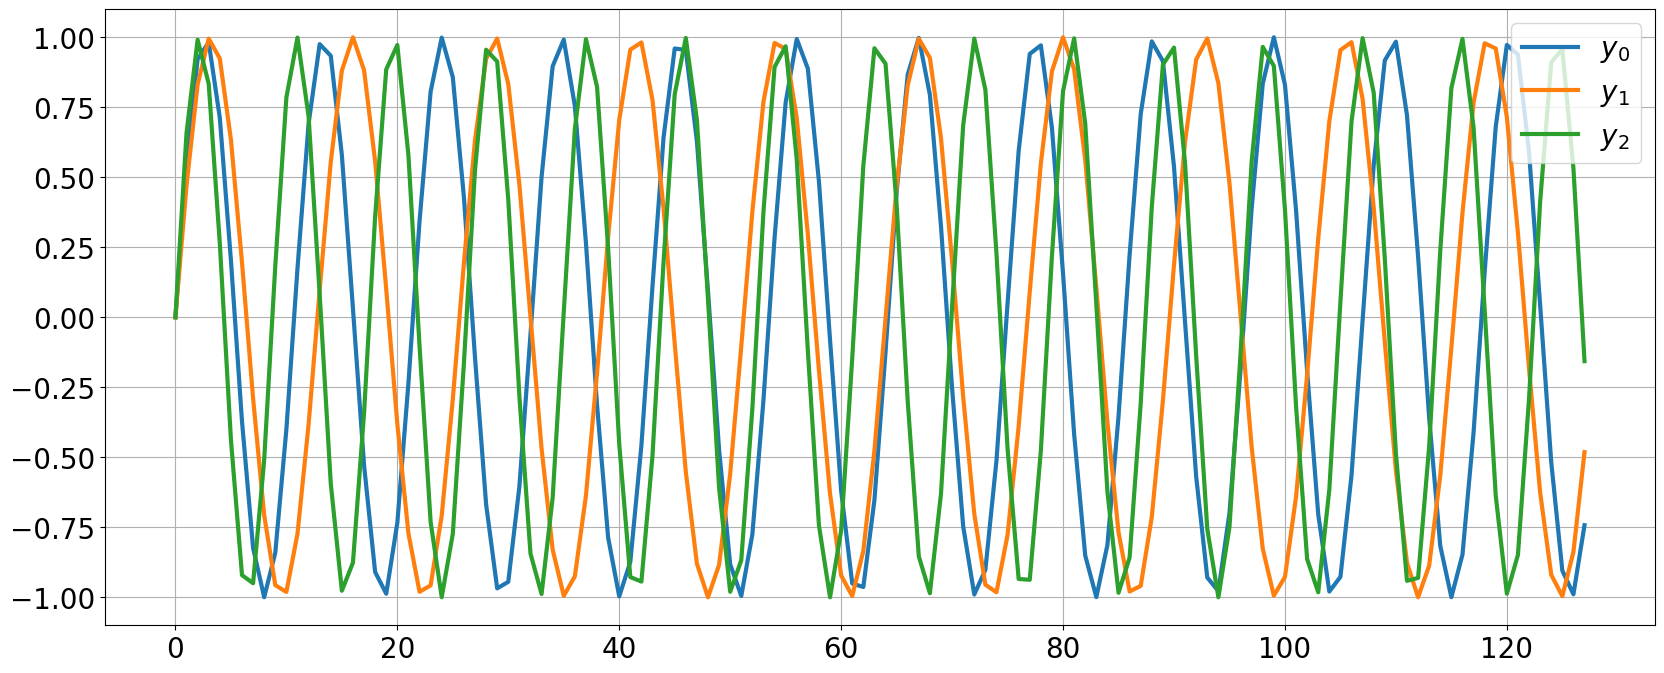

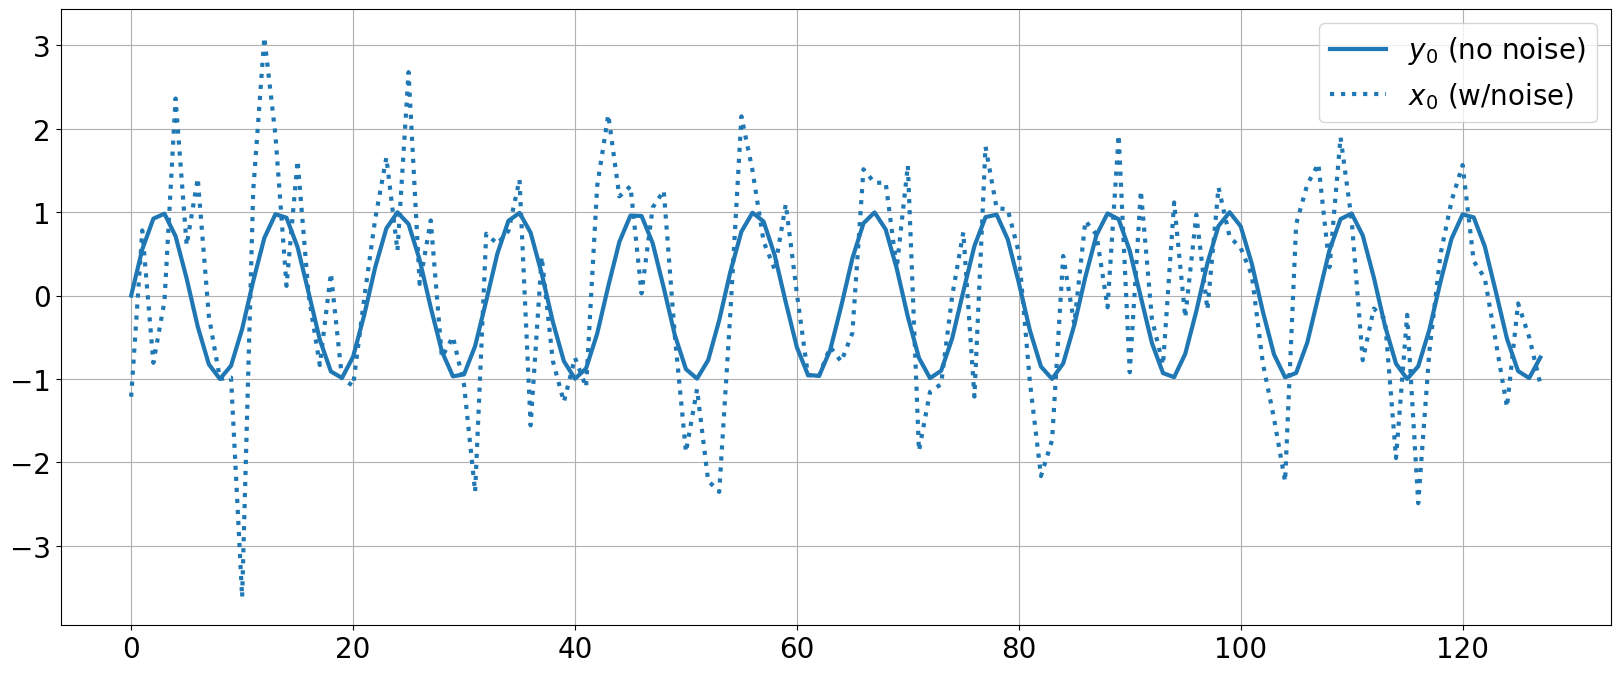

In [7]:
#############
# Les données
#############
n_examples = 50
x_len = 128

# Ensemble d'entrainement: des sinus purs avec des fréquences tirées aléatoirement autour de fc
fc = 0.1
df = 0.05
nu0_train = fc + np.random.rand(n_examples) * df - df / 2
y_true_train = np.sin(2 * np.pi * nu0_train[:, None] * np.arange(x_len)[None, :])
x_train = y_true_train + 10 ** 0 * np.random.randn(n_examples, x_len)

# Test set: signals with same 
nu0_test = fc + np.random.rand(n_examples) * df - df / 2
y_true_test = np.sin(2 * np.pi * nu0_test[:, None] * np.arange(x_len)[None, :])
x_test = y_true_test + 10 ** 0 * np.random.randn(n_examples, x_len)

plt.figure(figsize=(20, 8))
for i in range(3):
    plt.plot(y_true_train[i, :], '-', label='$y_{}$'.format(i))
plt.legend(loc='upper right')

plt.figure(figsize=(20, 8))
i = 0
p = plt.plot(y_true_train[i, :], '-', label='$y_0$ (no noise)'.format(i))
plt.plot(x_train[i, :], ':', label='$x_0$ (w/noise)'.format(i), color=p[0].get_color())
plt.legend(loc='upper right')

On construit un réseau composé d'une couche convolutive avec un filtre et une fonction d'activation linéaire. On optimise les poids du filtre en minimisant l'erreur aux moindres carrés.

c:\Users\bausm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Text(0.5, 1.0, 'Loss')

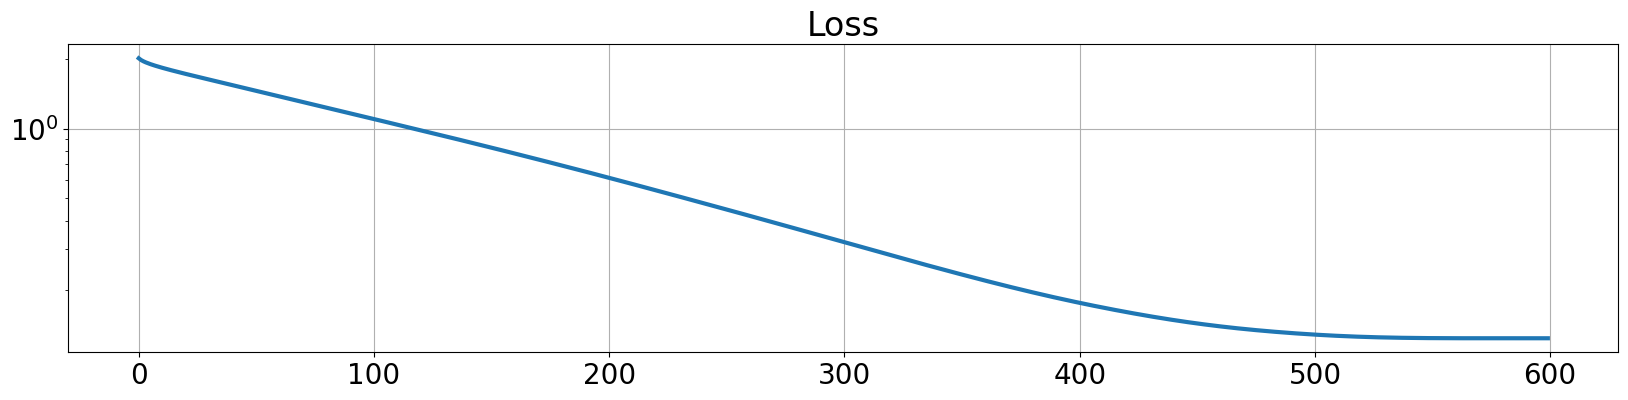

In [8]:
# Define and learn filter
h_len = 13

learning_model = Sequential()
# Note that input shape should be (x_len, n_input_channels)
conv_layer = Conv1D(filters=1, kernel_size=(h_len, ), padding='same',
                    activation='linear', strides=1, input_shape=(x_len, 1),
                    use_bias=False, name='fir')
learning_model.add(conv_layer)
learning_model.compile(optimizer='rmsprop', loss='mse')
history = learning_model.fit(x_train[:, :, None], y_true_train[:, :, None],
                             epochs=600, batch_size=n_examples, verbose=0)

plt.figure()
plt.semilogy(history.history['loss'])
plt.title('Loss')

Un aperçu des résultats sur l'ensemble de test.
Pour mesurer la qualité d'un signal $\widehat{y}$ par rapport au signal original $y$, on utilise le rapport signal à bruit (SNR)
$$SNR(\widehat{y}, y) = 20 \log \frac{\left\|y\right\|_2}{\left\|y-\widehat{y}\right\|_2}$$
qui d'autant plus élevé que $\widehat{y}$ proche de $y$.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
SNR avant débruitage: -3.1657427037742876
SNR après débruitage: 5.814192821862439


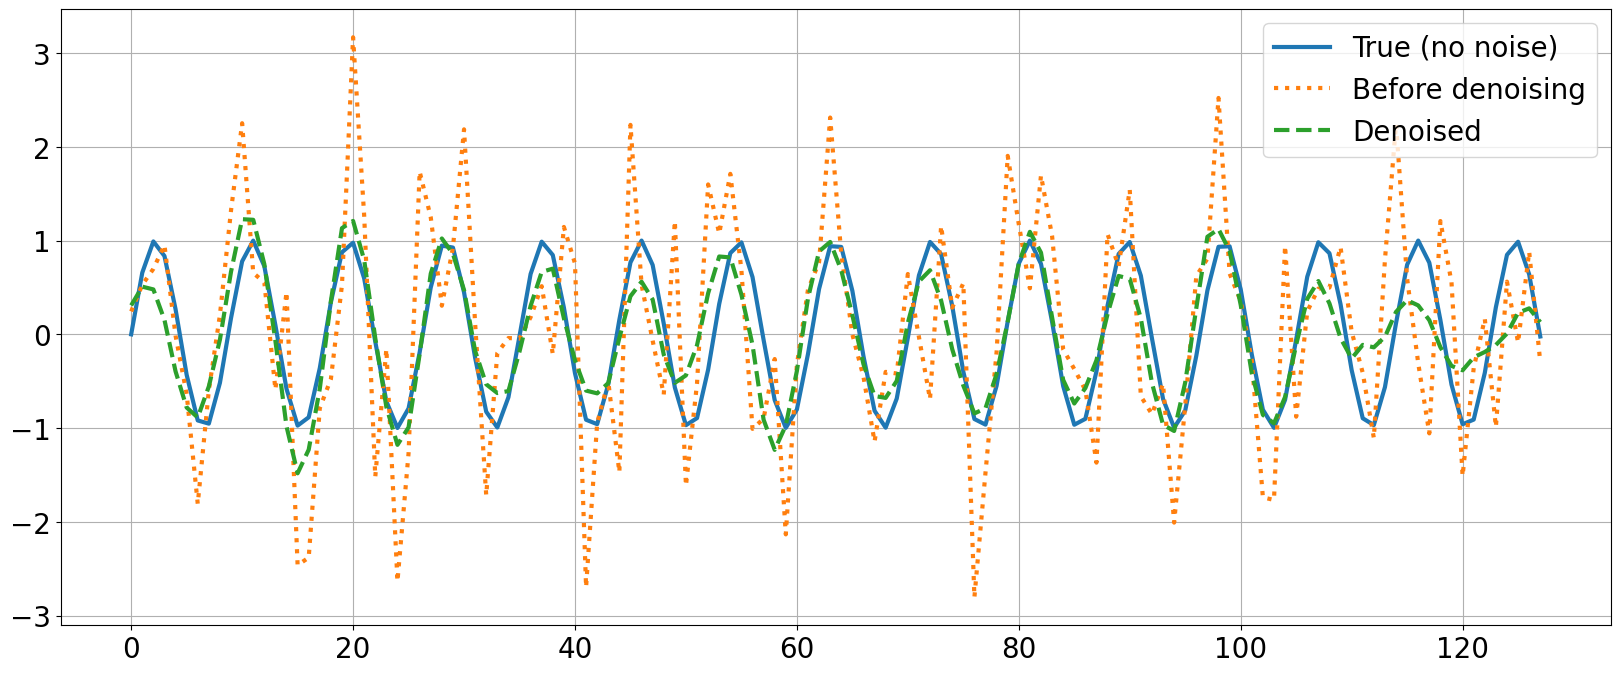

In [9]:
def db(x):
    return 20 * np.log10(np.abs(x))


def snr(x_est, x_true, axis=None):
    """ Signal-to-noise ratio """
    return db(np.linalg.norm(x_true, ord=2, axis=axis)
              / np.linalg.norm(x_est - x_true, ord=2, axis=axis))


y_learning_test = learning_model.predict(x_test[:, :, None])[:, :, 0]

print('SNR avant débruitage:',
      np.mean(snr(x_test, y_true_test, axis=1)))
print('SNR après débruitage:',
      np.mean(snr(y_learning_test, y_true_test, axis=1)))

plt.figure(figsize=(20, 8))
for i in range(1):
    plt.plot(y_true_test[i, :], '-', label='True (no noise)'.format(i))
    plt.plot(x_test[i, :], ':', label='Before denoising'.format(i))
    plt.plot(y_learning_test[i, :], '--', label='Denoised'.format(i))
plt.legend(loc='upper right')

# Visualisation du filtre appris
Comment interpréter ce qu'on a appris?

Text(0.5, 1.0, 'Filtre')

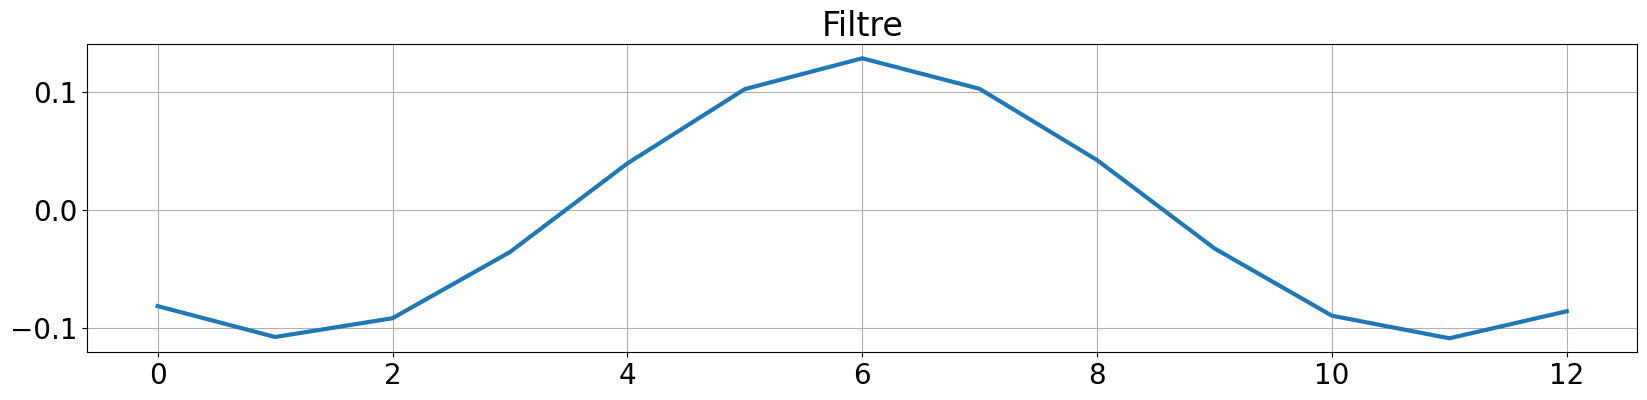

In [10]:
w_learning = learning_model.get_layer(name='fir').get_weights()[0].reshape(-1)

plt.figure()
plt.plot(w_learning)
plt.title('Filtre')

Text(0.5, 1.0, '"Réponse fréquentielle"')

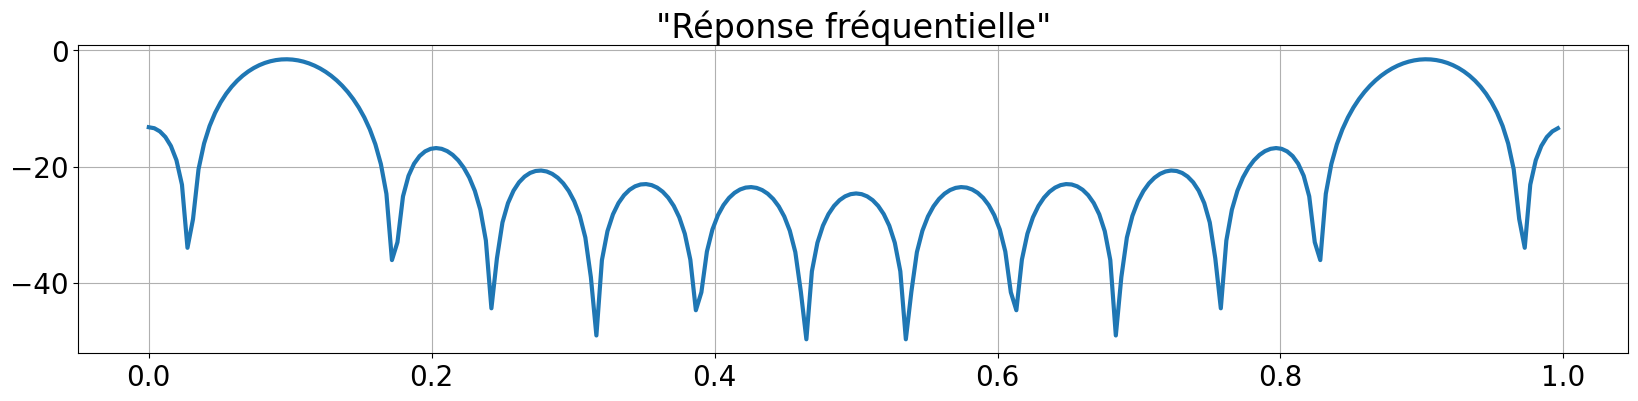

: 

In [ ]:
plt.figure()
n_bins = 256
plt.plot(np.arange(n_bins) / n_bins, db(np.fft.fft(w_learning, n_bins)))
plt.title('"Réponse fréquentielle"')